In this notebook, we

* load up the saved .png files.
* read the image into a numpy array.
* partition the image into individual arrays (recall that each image is '012345689') representing each number.
* resize each digit image into 16*16

The features are the eigenvectors for each image array. Thus, if we have n images in our training set, this process produces an n * 16 feature matrix.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import cv2
import os

image_dir = os.path.join(os.getcwd(), 'font_images')

if not os.path.isdir(image_dir) or len(os.listdir(image_dir)) == 0:
    print('no images found in {}'.format(image_dir))

First, we outline the processing for a single image.

In [3]:
img_mat = cv2.imread(os.path.join(image_dir, 'arial.png'))

# Convert to grayscale
gs = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)

In [4]:
gs.shape

(124, 911)

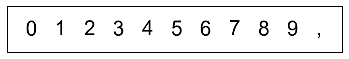

In [6]:
pylab.imshow(gs, cmap='gray')
pylab.tick_params(
        axis='both',          # changes apply to the x-axis and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', left='off', right='off', # don't display ticks
        labelbottom='off', labeltop='off', labelleft='off', labelright='off' # don't display ticklabels
) 

In [13]:
# Partition the columns into 10 equal parts
split_positions = np.linspace(0, gs.shape[1], num=12).astype(np.int)
split_positions = split_positions[1:-1]

# manual tweak by inspection
split_positions[0] += 10 

split_positions

array([ 92, 165, 248, 331, 414, 496, 579, 662, 745, 828])

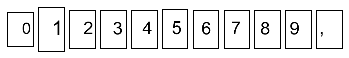

In [16]:
parts = np.array_split(gs, split_positions, axis=1)

fig, axes = pylab.subplots(1, len(parts))

for part, ax in zip(parts, axes):
    ax.imshow(part, cmap='gray')
    ax.tick_params(
        axis='both',          # changes apply to the x-axis and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', left='off', right='off', # don't display ticks
        labelbottom='off', labeltop='off', labelleft='off', labelright='off' # don't display ticklabels
)

In [48]:
# Resize to 128 * 128, binarize and calculate the eigenvalues.

for p in parts:
    resized = cv2.resize(p, (16, 16))
    _, binarized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)
    binarized[binarized==255] = 1
    
    eigvals = np.linalg.eig(binarized)[0]
    print(np.real(eigvals))

[  1.54205693e+01   4.27869407e-01   1.51561313e-01   2.38736048e-16
   2.38736048e-16  -2.55820649e-16  -3.97750884e-17  -3.97750884e-17
  -1.19366625e-16  -1.19366625e-16   6.40858907e-11  -6.40857840e-11
   6.84227766e-49   8.85927774e-33   0.00000000e+00   0.00000000e+00]
[  1.55540911e+01   2.22954469e-01   2.22954469e-01  -2.44527632e-16
   1.86023734e-16  -3.84878837e-17  -3.84878837e-17   3.50099623e-31
   3.50099623e-31  -2.92348569e-46  -1.71538467e-47   0.00000000e+00
  -1.53144517e-61  -1.91761463e-93  -2.59085057e-77   0.00000000e+00]
[  1.54914134e+01  -9.14797984e-01   4.23384551e-01   2.17813817e-16
   2.17813817e-16  -2.16079390e-16   2.31564749e-16   7.30519585e-17
   7.30519585e-17   1.35883639e-16  -3.79291019e-18  -2.48516640e-17
  -9.96951971e-34  -7.69756237e-49   0.00000000e+00   0.00000000e+00]
[  1.53103302e+01  -9.06106850e-01   1.22252782e-01   1.22252782e-01
   3.51271067e-01  -3.01063545e-16  -5.54647320e-17  -5.54647320e-17
   1.90243240e-16  -7.40260527e

Now, we package all of above into a single function. Then we iterate over all the saved files and produce the feature matrix.

In [50]:
def split_into_parts(img_file, n_parts):
    """
    - Read an image file.
    - Convert to grayscale.
    - Split into subarray for each char.
    - Return list of parts.    
    """
    assert os.path.isfile(img_file)   
    
    img_mat = cv2.imread(img_file)    
    gs = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    split_positions = np.linspace(0, gs.shape[1], num=n_parts+1).astype(np.int)
    split_positions = split_positions[1:-1]

    # manual tweak by inspection
    split_positions[0] += 10
    
    parts = np.array_split(gs, split_positions, axis=1)
    return parts

In [60]:
def eigenvalues(img_file, class_labels, threshold=127, n_dims=16):
    """
    Return eigenvalues for the resized subarrays from a collection of char images.
    
    Output is a len(class_labels) * n_dims DataFrame.
    """
    
    n_classes = len(class_labels)    
    parts = split_into_parts(img_file, n_classes)
    
    assert len(parts) == n_classes
    
    eigs = np.zeros([n_classes, n_dims])    
    columns = ['eig_{}'.format(k+1) for k in range(n_dims)]
    
    for i, p in enumerate(parts):        
        resized = cv2.resize(p, (n_dims, n_dims))
        _, binarized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)
        binarized[binarized==255] = 1  
        eigvals = np.linalg.eig(binarized)[0]
        eigs[i, :] = eigvals
        
    eig_df = pd.DataFrame(eigs, index=class_labels, columns=columns)    
    return eig_df
    

In [62]:
from IPython.display import display
from ipywidgets import FloatProgress

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

prog = FloatProgress(min=1, max=len(image_files), description='generating eigenvalues...')
display(prog)

features = []

for file_path in image_files:
    class_labels = ['zero', 'one', 'two', 'three', 
                    'four', 'five', 'six', 'seven', 
                    'eight', 'nine', 'comma']
    features.append(eigenvalues(file_path, class_labels))
    prog.value += 1
    
prog.bar_style = 'success'

d:\Anaconda3\envs\latest\lib\site-packages\ipykernel\__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


In [63]:
len(features)

136

In [64]:
features_df = pd.concat(features, axis=0)

In [65]:
features_df.describe()

,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16
count,1496.000000,1496.000000,1496.000000,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03
mean,15.190569,-0.346379,-0.040642,5.293787e-02,1.531367e-02,1.051875e-03,8.117539e-04,8.021390e-03,1.737968e-02,6.684492e-04,3.342246e-03,-4.495511e-12,-5.053628e-13,2.313848e-19,6.403026e-20,7.421277e-20
std,1.748524,2.022997,0.582395,4.041074e-01,2.883422e-01,1.897178e-01,1.398886e-01,1.031405e-01,1.307251e-01,4.479109e-02,5.773477e-02,2.392494e-10,1.954647e-11,6.120414e-18,2.611545e-18,2.870413e-18
min,0.000000,-2.717798,-1.980612,-1.530185e+00,-1.234650e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.530200e-09,-1.000000e+00,-1.076865e-08,-4.569597e-09,-7.560214e-10,-8.326673e-17,-2.775558e-17,-1.540744e-33
25%,15.184799,-1.090358,-0.522424,-3.882645e-16,-1.984775e-16,-1.920855e-16,-1.260043e-16,-8.463037e-17,-3.549181e-17,-2.077317e-17,-7.716947e-18,-5.926942e-32,-1.519291e-64,-1.663266e-111,0.000000e+00,0.000000e+00
50%,15.405304,-0.668683,0.031271,2.139802e-16,7.735943e-17,2.627435e-46,5.961922e-34,-2.127007e-62,-1.059500e-65,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,15.592047,0.062746,0.318854,1.874991e-01,5.629490e-16,2.490191e-16,1.587509e-16,9.399585e-17,7.005132e-17,2.531489e-17,1.107976e-17,2.247102e-20,2.967365e-67,1.170419e-97,0.000000e+00,0.000000e+00
max,15.937254,16.000000,1.878494,1.703434e+00,1.248518e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.977782e-09,1.149923e-16,1.249001e-16,8.326673e-17,1.110223e-16


In [66]:
feature_file = os.path.join(os.getcwd(), 'digit_eigenvalues.csv')
features_df.to_csv(feature_file, index_label='label')